# Se o Brasil saísse da Copa do Mundo Catar 2022, quem venceria ?

Tema do vídeo que coloquei no meu canal no Youtube @eusouolelis

Para acompanhar, segue o link: https://www.youtube.com/watch?v=VyjYdv2L0m4 

In [1]:
import pandas as pd
import numpy as np
import pickle

#viz
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import pyplot as plt

In [2]:
with open('world_cup_sim/gb_V2.pkl' , 'rb') as f:
    gb = pickle.load(f)

In [3]:
knockout_stage_matches = [
    ['Netherlands', 'United States'],
    ['Argentina', 'Australia'],
    ['Japan', 'Croatia'],
    ['Brazil', 'South Korea'],
    ['Senegal', 'England'],
    ['Poland', 'France'],
    ['Spain', 'Morocco'],
    ['Switzerland', 'Portugal']
]

quarter_finals = [
    ['Brazil', 'Croatia'],
    ['Netherlands', 'Argentina'],
    ['England', 'France'],
    ['Morocco', 'Portugal']
]

In [4]:
base_df = pd.read_csv("world_cup_sim/team_stats.csv")
base_df.columns

Index(['date', 'team', 'score', 'suf_score', 'rank', 'rank_suf', 'rank_change',
       'total_points', 'result', 'rank_dif', 'points_by_rank', 'team_points'],
      dtype='object')

In [5]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = base_df[(base_df["team"] == team_1)].sort_values("date")
    last5 = base_df[(base_df["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [6]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

In [7]:

playoffs = {"Quarter-Final": [], "Semi-Final": [], "Final": []}

In [8]:
def get_match_results(game):
    
    team_1 = find_stats(game[0])
    team_2 = find_stats(game[1])
    
    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)
    
    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    return [game[0], game[1], [team_1_prob, team_2_prob]]
    

In [9]:
def get_brazil_off(playoffs_stage):
    for p in playoffs.keys():
        playoffs[p] = []

    next_rounds = []

    for p in playoffs.keys():
        if p == "Quarter-Final":
            playoffs[p] = quarter_finals
        else:
            playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(len(next_rounds)-1) if c%2 == 0]
            next_rounds = []
        for i in range(len(playoffs[p])):
            game = get_match_results(playoffs[p][i])
            if p == playoffs_stage:
                if 'Brazil' in game[0] and game[2][0]>game[2][1]:
                    aux = game[0]
                    game[0] = game[1]
                    game[1] = aux
                elif 'Brazil' in game[1] and game[2][0]<game[2][1]:
                    aux = game[0]
                    game[0] = game[1]
                    game[1] = aux
            
            playoffs[p][i] = game
            
            team_1 = game[0]    
            team_1_prob = game[2][0]
            team_2 = game[1]
            team_2_prob = game[2][1]
            
            if team_1_prob > team_2_prob:
                next_rounds.append(team_1)
            else:
                next_rounds.append(team_2)
            
    return playoffs        

In [34]:
def get_graph_playoffs(playoffs,phase):
    plt.figure(figsize=(15, 10))
    G = nx.balanced_tree(2, 2)
    
    labels = []

    for p in playoffs.keys():
        for game in playoffs[p]:
            label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
            labels.append(label)
        
    labels_dict = {}
    labels_rev = list(reversed(labels))

    for l in range(len(list(G.nodes))):
        labels_dict[l] = labels_rev[l]

    pos = graphviz_layout(G, prog='dot')#prog='twopi')
    labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
    center  = pd.DataFrame(pos).mean(axis=1).mean()
        

    nx.draw(G, pos = pos, with_labels=False, edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
    nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                            labels=labels_dict)
    
    tit = {"Quarter-Final": "Brasil perdendo nas Quartas de Final", "Semi-Final": "Brasil perdendo na Semi-final", "Final": "Brasil perdendo na Final"}
    plt.title(tit[phase],fontsize = 40, fontweight='bold')
    plt.axis('equal')
    plt.show()

# Marrocos passa... E Portugal faz 6x1, E AS PREVISÕES AGORA ???

## O caminho até aqui: 

- REAL:

    * [['Netherlands', 'Senegal'],
    * ['England', 'United States'],
    * ['Argentina', 'Poland'],
    * ['France', 'Australia'],
    * ['Japan', 'Spain'],
    * ['Morocco', 'Croatia'],
    * ['Brazil', 'Switzerland'],
    * ['Portugal', 'South Korea']]
    

- PREDITO:

    * [['Netherlands', 'Senegal']
    * ['England', 'United States'],
    * ['Argentina', 'Poland'],
    * ['France', 'Denmark'],
    * ['Spain', 'Germany'],
    * ['Belgium', 'Croatia'],
    * ['Brazil', 'Switzerland'],
    * ['Portugal', 'Uruguay']]

        

- dos 16 times, errou 1+2(1)+1+1 = 5 => 68.75% de acerto !

- Nas oitavas de final, o único erro de resultado predito pelo modelo foi Marrocos ! Ou seja, 1/8 => 87.5% de acerto !

- OBS1) O modelo foi gerado utilizando dados históricos oficiais. Que não "viram" tantos jogos do Marrocos. Além disso, Marrocos nunca apresentou desempenho tão positivo !

- Quando se contrói um modelo, o que se deseja é um desempenho satisfatório em dados nunca vistos antes. Generalização.

- Embora tenha se percebido uma grande evolução e equiparação dos times em geral, ao analisarmos a história das finais de todas as Copas, os únicos times que não aparecem são Portugal e Marrocos. Ou seja, 75% tem um histórico forte... mas aguardemos as cenas dos próximos capítulos...  


# Análise: CASO O BRASIL FIQUE OFF NA COPA DO MUNDO:

4 possibilidade de OFF:

- Final
- Semi-Final 
- Quarter-Final 
- Round of 16 (\*)

<hr>

# OFF na FINAL 

In [20]:
phase='Final'
playoffs_without_brazil_final = get_brazil_off(phase)
playoffs_without_brazil_final

{'Quarter-Final': [['Brazil',
   'Croatia',
   [0.6620755016538931, 0.33792449834610694]],
  ['Netherlands', 'Argentina', [0.5102178589565887, 0.4897821410434113]],
  ['England', 'France', [0.5144021513808086, 0.4855978486191915]],
  ['Morocco', 'Portugal', [0.32683158265181106, 0.6731684173481889]]],
 'Semi-Final': [['Brazil',
   'Netherlands',
   [0.5454656140191929, 0.45453438598080714]],
  ['England', 'Portugal', [0.5148905633327507, 0.4851094366672492]]],
 'Final': [['England', 'Brazil', [0.5557902023389737, 0.4442097976610263]]]}

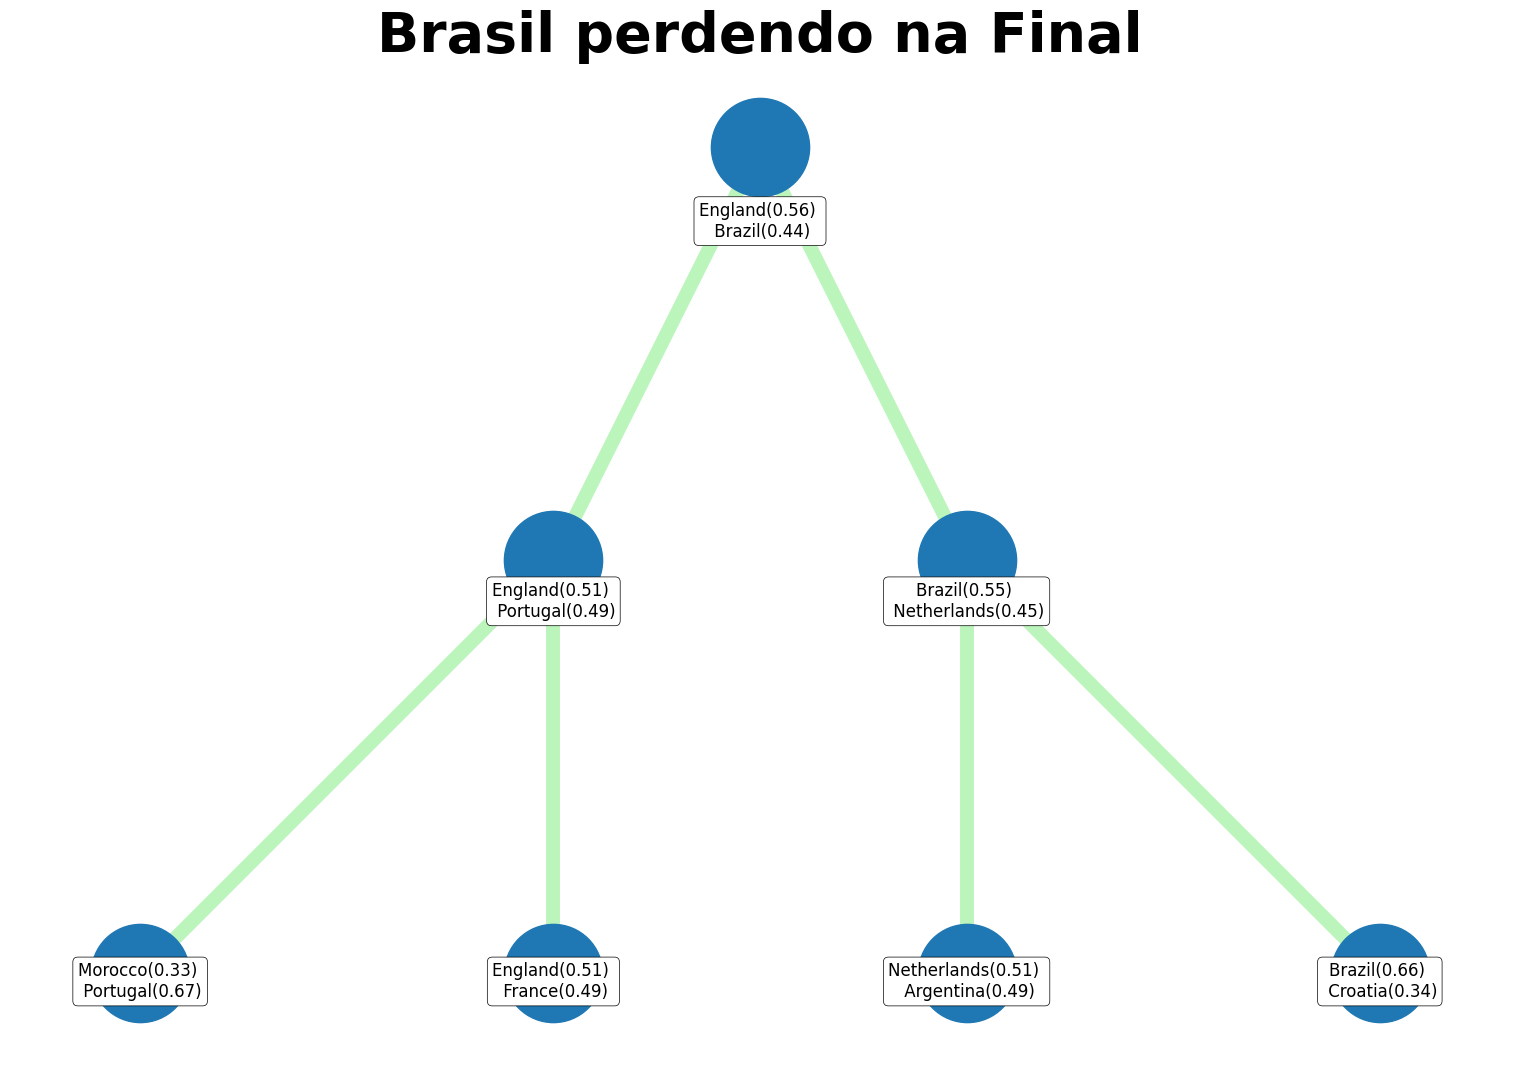

In [33]:
get_graph_playoffs(playoffs_without_brazil_final,phase)

In [35]:
phase='Semi-Final'
playoffs_without_brazil_semi_final = get_brazil_off(phase)
playoffs_without_brazil_semi_final

{'Quarter-Final': [['Brazil',
   'Croatia',
   [0.6620755016538931, 0.33792449834610694]],
  ['Netherlands', 'Argentina', [0.5102178589565887, 0.4897821410434113]],
  ['England', 'France', [0.5144021513808086, 0.4855978486191915]],
  ['Morocco', 'Portugal', [0.32683158265181106, 0.6731684173481889]]],
 'Semi-Final': [['Netherlands',
   'Brazil',
   [0.5454656140191929, 0.45453438598080714]],
  ['England', 'Portugal', [0.5148905633327507, 0.4851094366672492]]],
 'Final': [['Netherlands',
   'England',
   [0.5223363069692294, 0.4776636930307706]]]}

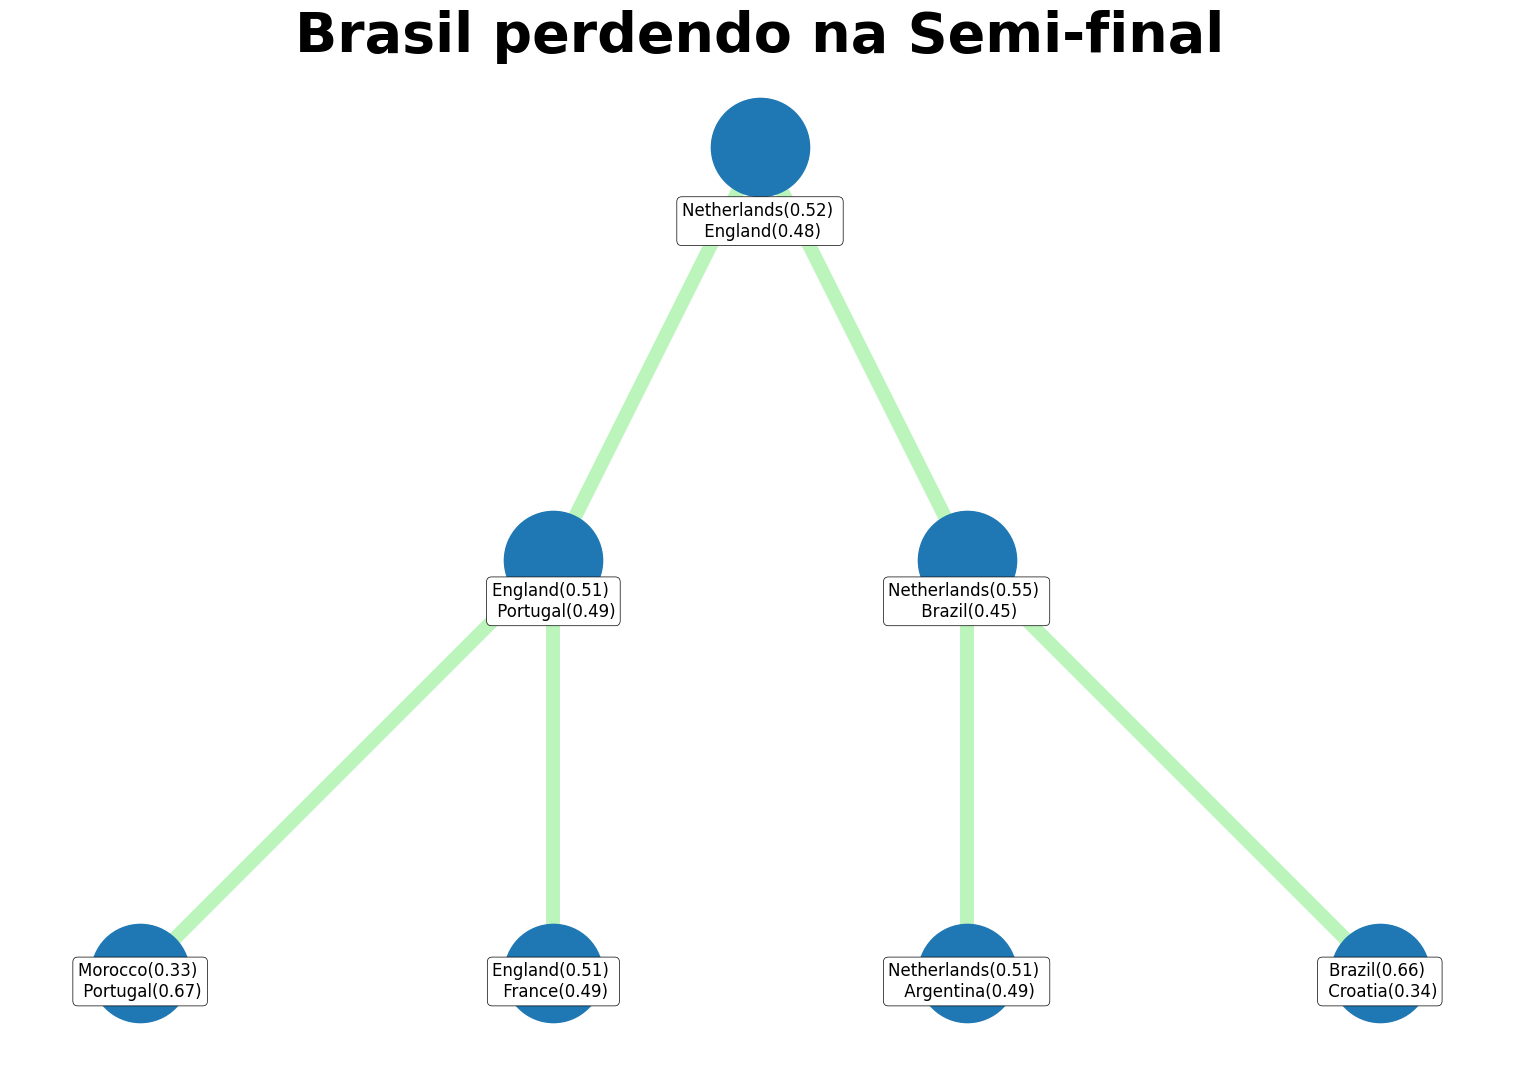

In [37]:
get_graph_playoffs(playoffs_without_brazil_semi_final,phase)

In [38]:
phase='Quarter-Final'
playoffs_without_brazil_quarter_final = get_brazil_off(phase)
playoffs_without_brazil_quarter_final

{'Quarter-Final': [['Croatia',
   'Brazil',
   [0.6620755016538931, 0.33792449834610694]],
  ['Netherlands', 'Argentina', [0.5102178589565887, 0.4897821410434113]],
  ['England', 'France', [0.5144021513808086, 0.4855978486191915]],
  ['Morocco', 'Portugal', [0.32683158265181106, 0.6731684173481889]]],
 'Semi-Final': [['Croatia',
   'Netherlands',
   [0.38717947502144157, 0.6128205249785584]],
  ['England', 'Portugal', [0.5148905633327507, 0.4851094366672492]]],
 'Final': [['Netherlands',
   'England',
   [0.5223363069692294, 0.4776636930307706]]]}

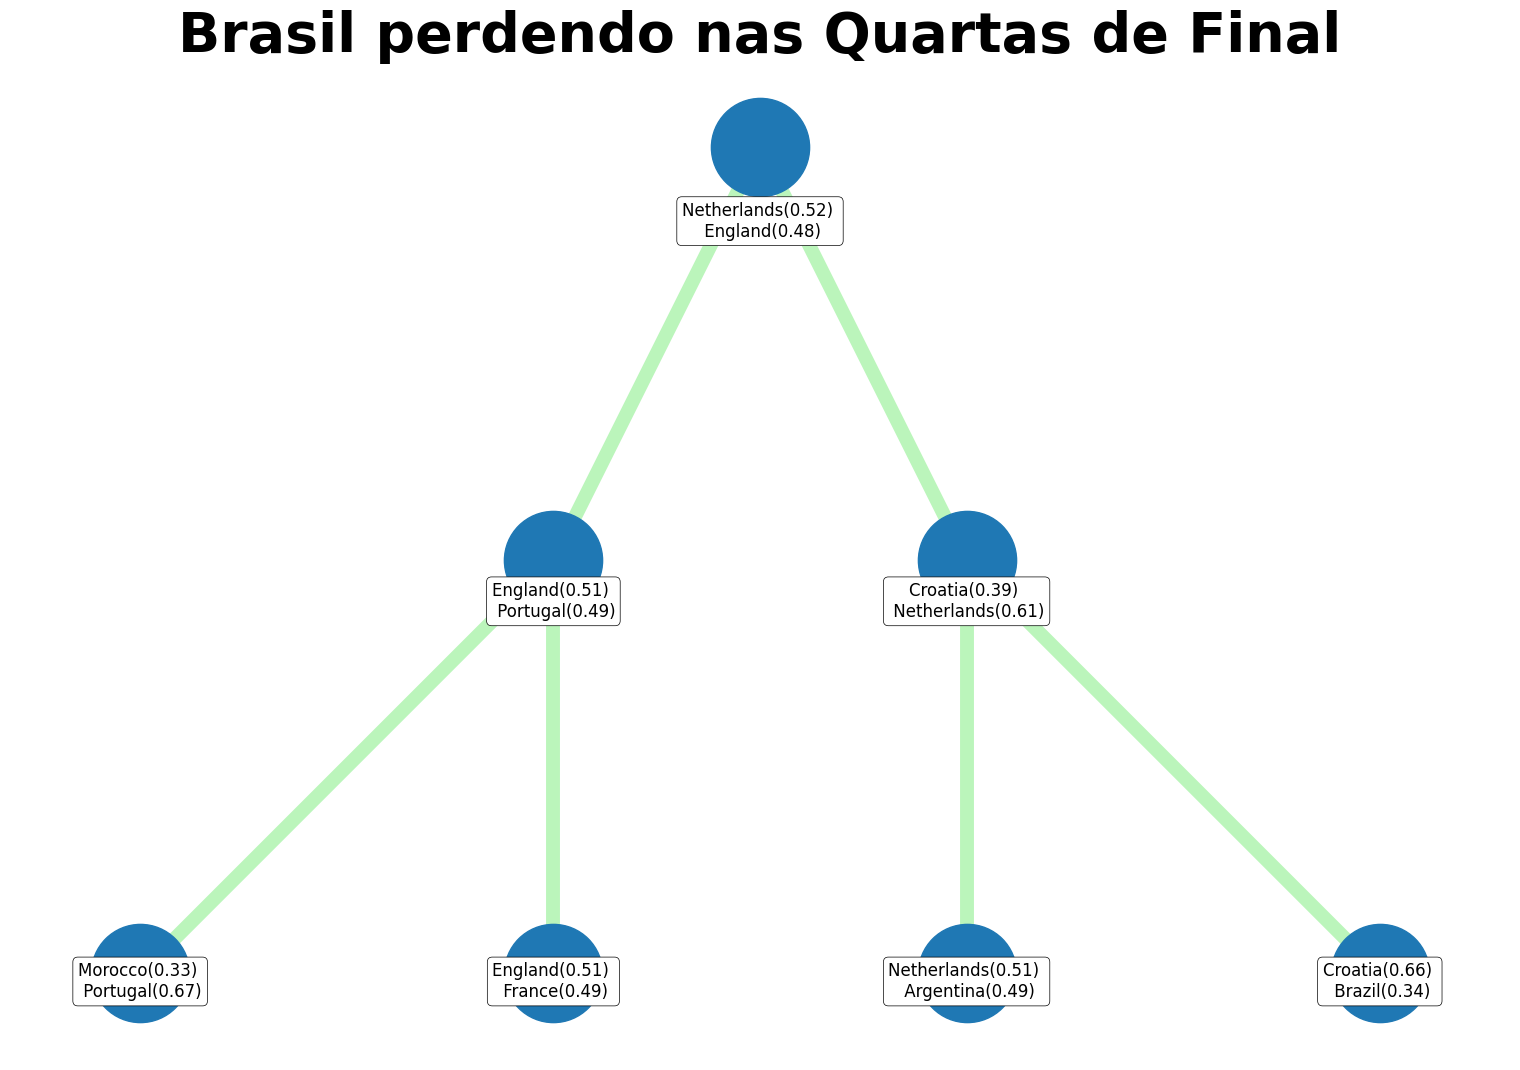

In [39]:
get_graph_playoffs(playoffs_without_brazil_quarter_final,phase)